In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm

In [2]:
def define_x(df, origin_fe=None):
    
    iso_codes = ['BEN', 'BFA', 'BWA', 'CMR', 'EGY', 
                 'ETH', 'GHA', 'GIN', 'LBR', 'MLI', 
                 'MOZ', 'MUS', 'MWI', 'RWA', 'SEN', 
                 'SLE', 'TGO', 'UGA', 'ZAF', 'ZMB']
    
    iso_df = pd.DataFrame({'aux': 1}, index=sorted(iso_codes))
    religs = ['Christian', 'Muslim', 'Traditional']
    

    x = (df[['iso', 'year', 'major_religion', 'org', 'migrant', 'w']]
         .groupby(['iso', 'year', 'major_religion', 'org', 'migrant'])
         .sum()
         .reset_index(drop=False))

    x = x.set_index(['iso', 'year', 'major_religion', 'org', 'migrant'], drop=True).unstack().fillna(0).reset_index(drop=False)
    x.columns = ['iso', 'year', 'major_religion', 'org', 'w0', 'w1']
    x['tot'] = x.w0 + x.w1
    x['shr'] = x.w1 / x.tot
    x.drop(['w0', 'w1'], axis=1, inplace=True)

    if origin_fe == 'unweighted':
        x['total_org_migshr'] = x.groupby(['iso', 'year', 'org'])['shr'].transform('mean')
        x['shr'] = x.shr - x.total_org_migshr        
        x.drop('total_org_migshr', axis=1, inplace=True)
    elif origin_fe == 'weighted':
        x['tottot'] = x.groupby(['iso', 'year', 'org'])['tot'].transform('sum')
        x['orgobshr'] = x.tot / x.tottot
        x['wshr'] = x.shr * x.orgobshr
        x['total_org_migshr'] = x.groupby(['iso', 'year', 'org'])['wshr'].transform('sum')

        x['shr'] = x.shr - x.total_org_migshr
        x.drop(['tottot', 'orgobshr', 'wshr', 'total_org_migshr'], axis=1, inplace=True)
    
    x['tottot'] = x.groupby(['iso', 'year', 'major_religion'])['tot'].transform('sum')
    x['orgshr'] = x.tot / x.tottot
    x['wshr'] = x.shr * x.orgshr

    x = x.groupby(['iso', 'year',  'major_religion'])[['wshr']].sum().reset_index(drop=False)
    x = x.groupby(['iso', 'major_religion'])[['wshr']].mean().reset_index(drop=False)
    
    return x

In [3]:
current_folder = globals()['_dh'][0]
rootdir = os.path.dirname(os.path.dirname(current_folder))
wdir = os.path.join(rootdir, '_2_intermediate', 'data')
outdir = os.path.join(rootdir, '_3_figures_tables', 'data')

In [4]:
df = pd.read_csv(os.path.join(wdir, 'migrant_stock_data_all.csv'))
df = df[df.bd==1980].reset_index(drop=True)
df_boot = pd.read_csv(os.path.join(wdir, 'migrant_stock_shares_boot_1980.csv'))

In [5]:
xnofe_plot = define_x(df, origin_fe=None)

In [6]:
xorgfe_plot = define_x(df, origin_fe="weighted")

In [7]:
xnofe = xnofe_plot[
    (xnofe_plot.major_religion.isin(['Christian', 'Muslim']))][
    ['iso', 'major_religion', 'wshr']
].set_index(['iso', 'major_religion'], drop=True).unstack().reset_index(drop=False)
xnofe.columns = ['iso', 'c', 'm']
xnofe['diff'] = xnofe.c - xnofe.m

xorgfe = xorgfe_plot[
    (xorgfe_plot.major_religion.isin(['Christian', 'Muslim']))][
    ['iso', 'major_religion', 'wshr']
].set_index(['iso', 'major_religion'], drop=True).unstack().reset_index(drop=False)
xorgfe.columns = ['iso', 'c', 'm']
xorgfe['diff'] = xorgfe.c - xorgfe.m

# Distribution plots without origin fixed effects

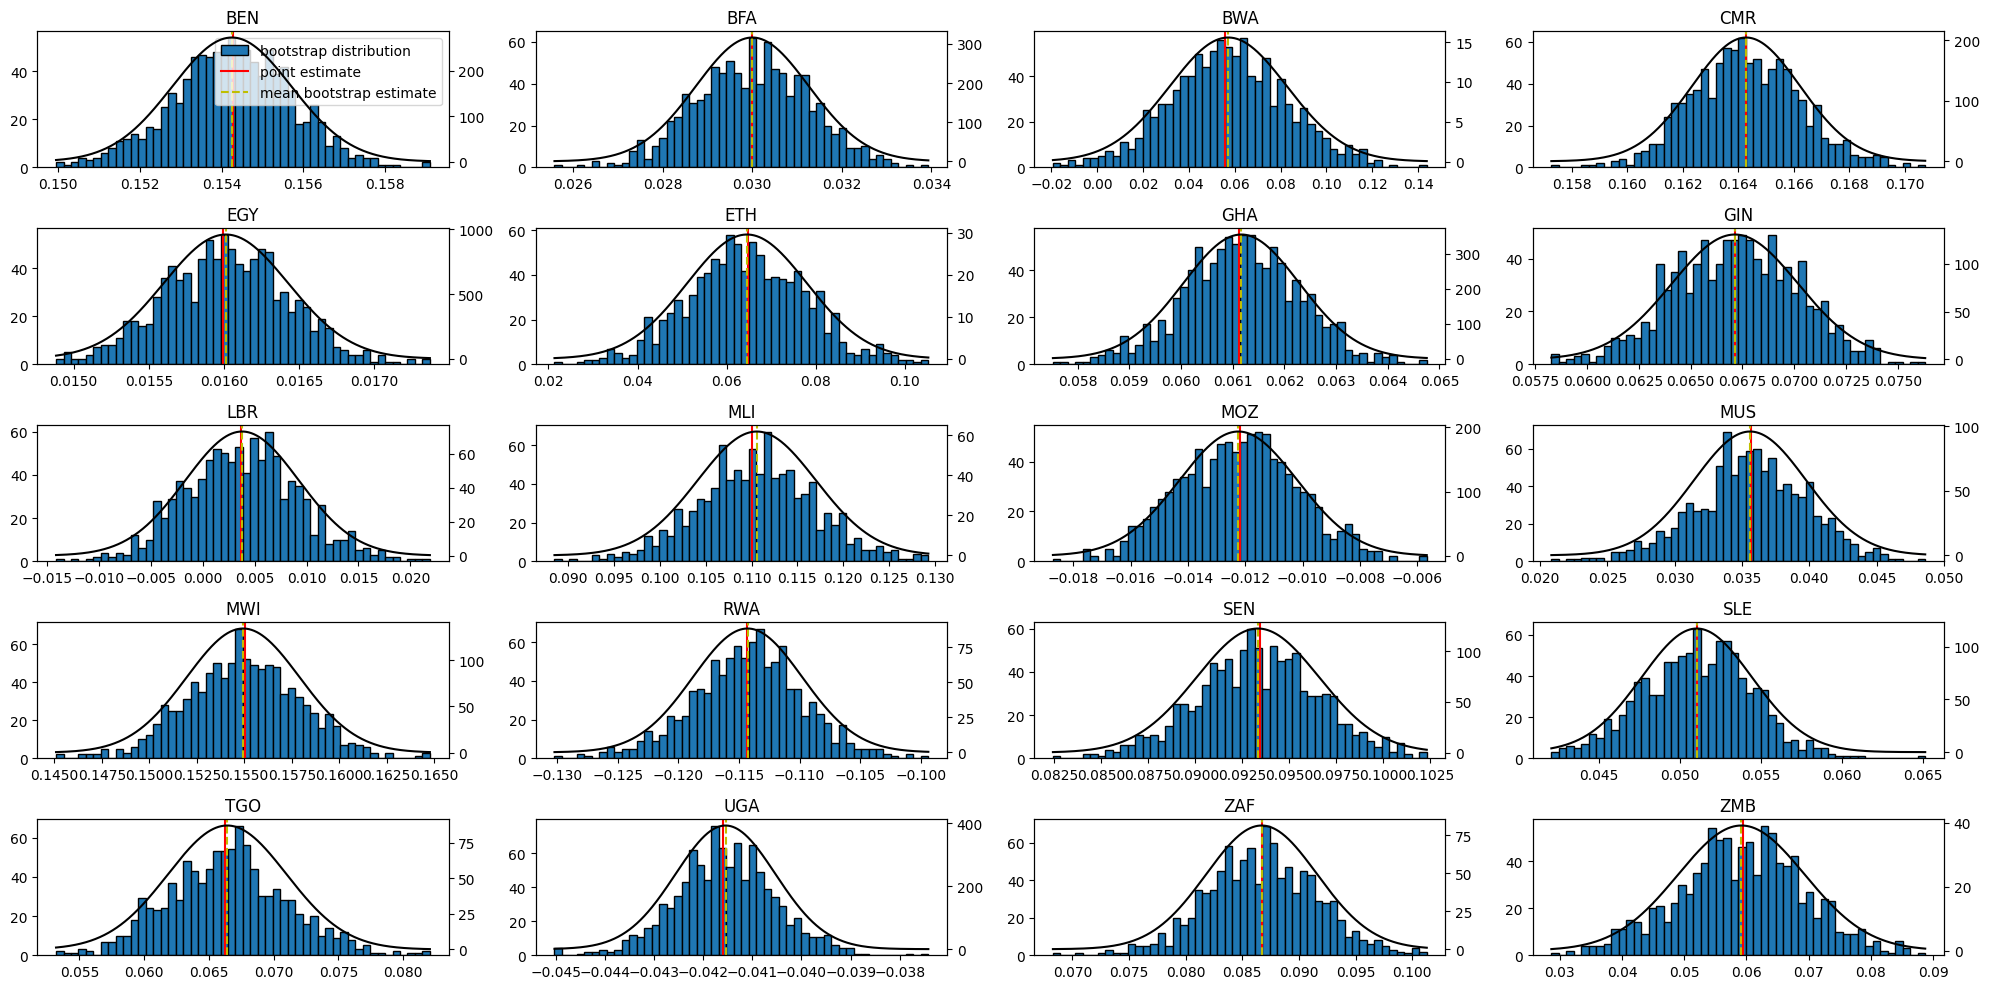

In [8]:
i, j = 0, 0
f, ax = plt.subplots(5, 4, figsize=(20, 10))
for iso in xnofe.iso:
    df_boot_iso = (
        df_boot[df_boot.iso==iso]
        .drop('iso', axis=1)
        .set_index(['iboot', 'major_religion'], drop=True)
        .unstack()
        .reset_index(drop=True)
    )['wshr']
    df_boot_iso['diff'] = df_boot_iso.Christian - df_boot_iso.Muslim
    xboot = np.linspace(df_boot_iso['diff'].min(), df_boot_iso['diff'].max(), 1000)
    ax[i,j].hist(df_boot_iso['diff'], bins=50, edgecolor='k', label='bootstrap distribution')
    ax[i,j].axvline(x=xnofe[xnofe.iso==iso]['diff'].values[0], color='r', label='point estimate')
    ax[i,j].axvline(x=df_boot_iso['diff'].mean(), color='y', label='mean bootstrap estimate', linestyle='--')
    axij2 = ax[i,j].twinx()
    axij2.plot(xboot,norm.pdf(xboot, df_boot_iso['diff'].mean(), df_boot_iso['diff'].std()), color='k')
    ax[i,j].set_title(iso)
    if i == 0 and j == 0:
        ax[i,j].legend()
    if j == 3:
        i += 1
        j = 0
    else:
        j += 1
f.tight_layout()
plt.show(f)

# Distribution plots with origin fixed effects

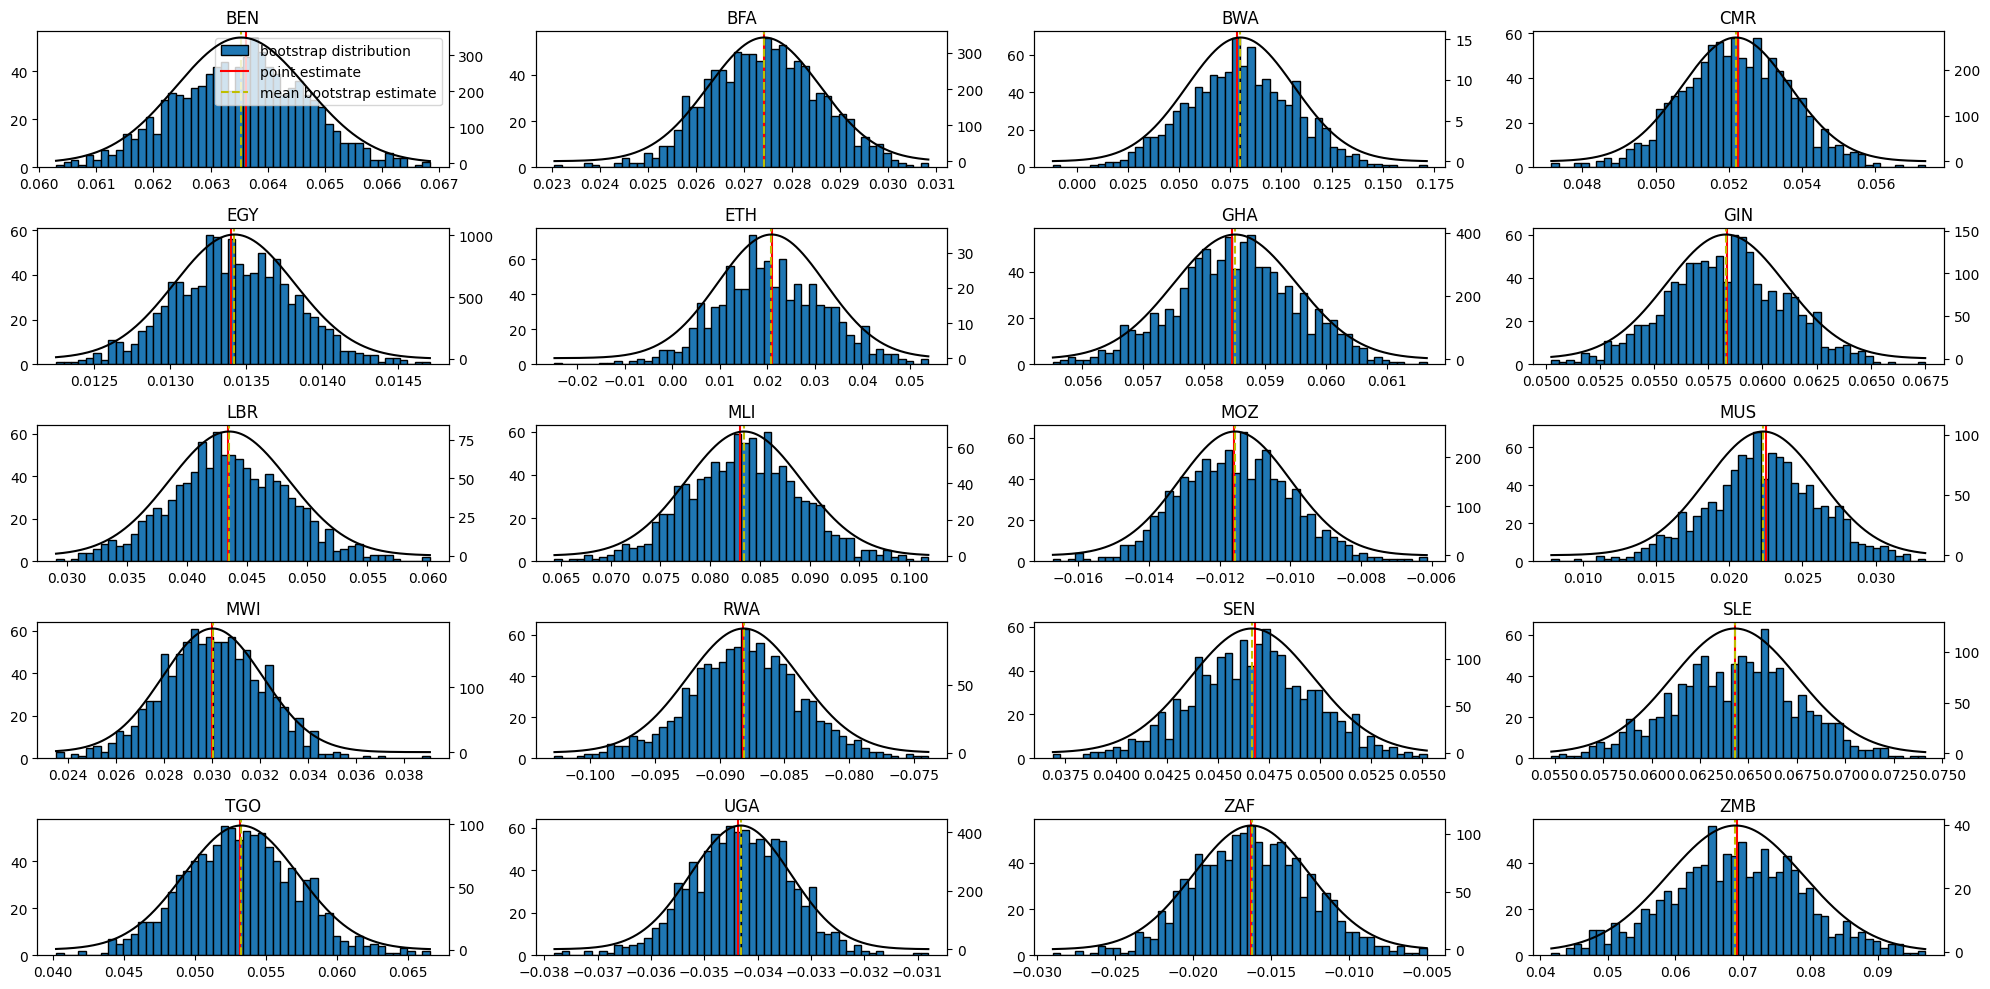

In [9]:
i, j = 0, 0
f, ax = plt.subplots(5, 4, figsize=(20, 10))
for iso in xorgfe.iso:
    df_boot_iso = (
        df_boot[df_boot.iso==iso]
        .drop('iso', axis=1)
        .set_index(['iboot', 'major_religion'], drop=True)
        .unstack()
        .reset_index(drop=True)
    )['wshr_dm']
    df_boot_iso['diff'] = df_boot_iso.Christian - df_boot_iso.Muslim
    xboot = np.linspace(df_boot_iso['diff'].min(), df_boot_iso['diff'].max(), 1000)
    ax[i,j].hist(df_boot_iso['diff'], bins=50, edgecolor='k', label='bootstrap distribution')
    ax[i,j].axvline(x=xorgfe[xorgfe.iso==iso]['diff'].values[0], color='r', label='point estimate')
    ax[i,j].axvline(x=df_boot_iso['diff'].mean(), color='y', label='mean bootstrap estimate', linestyle='--')
    axij2 = ax[i,j].twinx()
    axij2.plot(xboot,norm.pdf(xboot, df_boot_iso['diff'].mean(), df_boot_iso['diff'].std()), color='k')
    ax[i,j].set_title(iso)
    if i == 0 and j == 0:
        ax[i,j].legend()
    if j == 3:
        i += 1
        j = 0
    else:
        j += 1
f.tight_layout()
plt.show(f)

# Making the bar plots with stars

In [10]:
def make_stars(mu, sig):
    z  = mu/sig
    pv = norm.sf(abs(z))*2
    if pv < 0.01:
        return '***'
    elif pv < 0.05:
        return '** '
    elif pv < 0.1:
        return '*   '
    else:
        return '     '
    
def bar_plot(df, leg_loc, df_boot, bootcol):
    
    religs = ['Christian', 'Muslim', 'Traditional']
    df = df[(df.major_religion.isin(religs))].reset_index(drop=True)
    df = df.set_index(['iso', 'major_religion']).unstack().reset_index(drop=False)
    df.columns = ['iso', 'Christian', 'Muslim', 'Traditional']
    df = df.sort_values(['iso'], ascending=False).reset_index(drop=True)
    
    stars = (
        df_boot[df_boot.major_religion.isin(['Christian', 'Muslim'])][
            ['iso', 'iboot', 'major_religion', bootcol]]
        .set_index(['iso', 'iboot', 'major_religion'], drop=True)
        .unstack()
        .reset_index(drop=False)
    )
    stars['d'] = stars[bootcol].Christian - stars[bootcol].Muslim 
    stars = stars[['iso', 'd']].groupby(['iso']).agg(['mean', 'std'])['d'].reset_index(drop=False)
    stars.columns = ['iso', 'm', 's']
    stars['stars'] = stars.apply(lambda x: make_stars(x['m'], x['s']), axis=1)
    
    df = pd.merge(df, stars, on=['iso'], how='inner')

    labels = [iso  + ' ' + stars for iso, stars in zip(df.iso, df.stars) ]
    
    bar_width = 0.3
    x = np.arange(len(labels))
    f, ax = plt.subplots(figsize=(6, 10))
    ax.barh(x + bar_width, df.Christian, bar_width, label='Christian', color='r')
    ax.barh(x, df.Muslim, bar_width, label='Muslim', color='b')
    ax.barh(x - bar_width, df.Traditional, bar_width, label='Traditional', color='k') 
            
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.legend(loc=leg_loc, prop={'size': 12}, bbox_to_anchor=(-0.03,-0.11), ncol=3)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(x[0]-0.5, x[-1]+0.5)
    ax.grid(color='lightgray')
    ax.set_axisbelow(True)
    plt.close(f)
    return f

In [11]:
f = bar_plot(xnofe_plot, 'lower left', df_boot, 'wshr')
f.savefig(outdir + '/migshares_byc_bd1980_orgfe_none_stars.pdf', bbox_inches='tight')

In [12]:
f = bar_plot(xorgfe_plot, 'lower left', df_boot, 'wshr_dm')
f.savefig(outdir + '/migshares_byc_bd1980_orgfe_weighted_stars.pdf', bbox_inches='tight')